In [2]:
from numpy.random.bit_generator import SeedlessSeedSequence
import tensorflow as tf
import numpy as np
import random

#from tqdm import tqdm #Provides a progress bar while the images are being resized
from skimage.io import imshow, imread
from skimage.transform import resize
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import tifffile as tiff 
from patchify import patchify
from sklearn.model_selection import train_test_split
from patchify import patchify
from sklearn.metrics import jaccard_score,  accuracy_score, f1_score, make_scorer, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import cross_val_score
import random
seed = 42
np.random.seed=42
from spectral import *

ModuleNotFoundError: No module named 'keras.utils.vis_utils'

In [2]:
tf.random.set_seed(42)

In [3]:
from numpy.random.bit_generator import SeedlessSeedSequence
import tensorflow as tf
import os
import numpy as np
import random
from sklearn.utils import shuffle
#from tqdm import tqdm #Provides a progress bar while the images are being resized
from skimage.io import imshow, imread
from skimage.transform import resize
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import tifffile as tiff 
from patchify import patchify, unpatchify
from sklearn.model_selection import train_test_split
from patchify import patchify
from sklearn.metrics import jaccard_score,  accuracy_score, f1_score, make_scorer, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
import random
from keras import backend as K
seed =42
np.random.seed=42

from spectral import *

In [4]:
HEIGHT = 256
WIDTH = 256
CHANNELS = 5

In [5]:
X=[]
y=[]

for a in range(1,6):
  Xpath = '/Users/anshugusain/tf-nuclei/content/dataCubes/Field' + str(a) + '/cube_envi32.hdr'
  Ximg = spectral.open_image(Xpath)
  ypath = '/Users/anshugusain/tf-nuclei/content/Field-00' + str(a) + '-mask.png'
  yimg = tf.keras.preprocessing.image.load_img(ypath, grayscale=True)
  Field = Ximg.read_bands((25,41,86,101,133))

  Xpatches = patchify(Field,(HEIGHT,WIDTH,CHANNELS),step=HEIGHT)

  yimg = np.asarray(yimg)
  ypatches = patchify(yimg, (HEIGHT,WIDTH), step=HEIGHT)

  for m in range(0, Xpatches.shape[0]):
    for l in range(0, Xpatches.shape[1]):
      X.append(Xpatches[m,l,0])
      y.append(ypatches[m,l])

X = np.array(X)
y = np.array(y)

X = (X/X.max())
y = (y/y.max())



/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)
/Users/anshugusain/miniforge3/envs/tf-nuclei/lib/python3.9/site-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y ,random_state=42, test_size=0.05, shuffle=True)

In [7]:
X_train.shape

(28, 256, 256, 5)

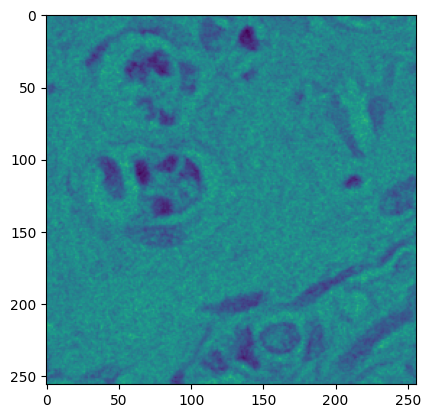

In [8]:
plt.imshow(X_train[26][:,:,0])

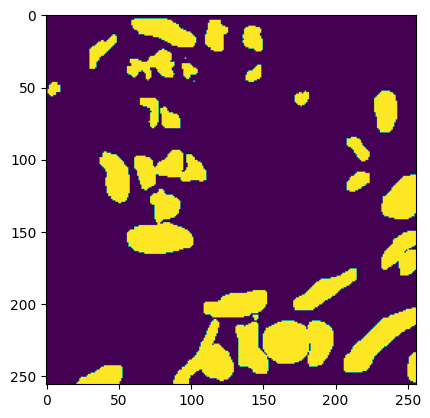

In [9]:
plt.imshow(y_train[26])

In [10]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

In [1]:
IMG_WIDTH= 256
IMG_HEIGHT= 256
IMG_CHANNELS= 5

#Building the model
 
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
s = inputs

#Contraction Path
                           # feature space  
                           # \/
c1 = tf.keras.layers.Conv2D(16,(3,3), activation = "relu", kernel_initializer='he_normal', padding = 'same')(s)#kernel initializer is the initial weights used by the neural network (he_normal is a trunkated normal distribution centered on 0)
c1 = tf.keras.layers.Dropout(.1)(c1)
c1 = tf.keras.layers.Conv2D(16,(3,3), activation = "relu", kernel_initializer="he_normal", padding = "same")(c1 ) #Padding ensures that the output image has the same dimensions as the input image
p1 = tf.keras.layers.MaxPooling2D((2,2))(c1) #First maxpooling layer puts the values into a 2x2 matrix, and gets the maximum values

c2 = tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
c2 = tf.keras.layers.Dropout(.1)(c2)
c2 = tf.keras.layers.Conv2D(32,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
p2=tf.keras.layers.MaxPooling2D((2,2))(c2)

c3= tf.keras.layers.Conv2D(64, (3,3), activation = "relu", kernel_initializer="he_normal", padding="same")(p2)
c3 = tf.keras.layers.Dropout(.2)(c3)
c3=tf.keras.layers.Conv2D(64,(3,3), activation = "relu", kernel_initializer="he_normal", padding="same")(c3)
p3=tf.keras.layers.MaxPooling2D((2,2))(c3)

c4= tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
c4= tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3,3),activation="relu", kernel_initializer="he_normal", padding="same")(c4)
p4=tf.keras.layers.MaxPooling2D((2,2))(c4)

c5=tf.keras.layers.Conv2D(256, (3,3), activation ="relu", kernel_initializer="he_normal", padding="same")(p4)
c5=tf.keras.layers.Dropout(0.3)(c5)
c5=tf.keras.layers.Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)
p5=tf.keras.layers.MaxPooling2D((2,2))(c5)

#Expansive Patch
u6= tf.keras.layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
u6= tf.keras.layers.concatenate([u6,c4])#Concatenates layers u6 and c4 as shown in the Unet architecture
c6=tf.keras.layers.Conv2D(128, (3,3), activation="relu", kernel_initializer='he_normal', padding="same")(u6)
c6=tf.keras.layers.Dropout(0.2)(c6)
c6=tf.keras.layers.Conv2D(128, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7=tf.keras.layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
u7=tf.keras.layers.concatenate([u7,c3])
c7=tf.keras.layers.Conv2D(64,(3,3), activation="relu",kernel_initializer="he_normal", padding="same")(u7)
c7=tf.keras.layers.Dropout(0.2)(c7)
c7=tf.keras.layers.Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

u8=tf.keras.layers.Conv2DTranspose(32, (2,2),strides=(2,2), padding="same")(c7)
u8=tf.keras.layers.concatenate([u8, c2])
c8=tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
c8=tf.keras.layers.Dropout(0.1)(c8)
c8=tf.keras.layers.Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2,2), strides=(2,2), padding='same')(c8)
u9=tf.keras.layers.concatenate([u9,c1])
c9=tf.keras.layers.Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
c9=tf.keras.layers.Dropout(0.1)(c9)
c9=tf.keras.layers.Conv2D(16,(3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)\


outputs=tf.keras.layers.Conv2D(1, (1,1), activation="sigmoid")(c9)
model=tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer = tf.keras.optimizers.legacy.Adam(), loss=[jacard_coef_loss], metrics=[jacard_coef])
model.summary()

NameError: name 'tf' is not defined

In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy',mode='max',patience=20)
results = model.fit(X_train, y_train, batch_size=1, epochs=75, verbose =1)

Epoch 1/75


2023-02-27 17:13:08.918903: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


28/28 [==============================] - 2s 26ms/step - loss: -0.1656 - jacard_coef: 0.1656
Epoch 2/75
28/28 [==============================] - 1s 20ms/step - loss: -0.1671 - jacard_coef: 0.1671
Epoch 3/75
28/28 [==============================] - 1s 20ms/step - loss: -0.1671 - jacard_coef: 0.1671
Epoch 4/75
28/28 [==============================] - 1s 20ms/step - loss: -0.1671 - jacard_coef: 0.1671
Epoch 5/75
28/28 [==============================] - 1s 20ms/step - loss: -0.1671 - jacard_coef: 0.1671
Epoch 6/75
28/28 [==============================] - 1s 21ms/step - loss: -0.1671 - jacard_coef: 0.1671
Epoch 7/75
28/28 [==============================] - 1s 20ms/step - loss: -0.1671 - jacard_coef: 0.1671
Epoch 8/75
28/28 [==============================] - 1s 21ms/step - loss: -0.1671 - jacard_coef: 0.1671
Epoch 9/75
28/28 [==============================] - 1s 20ms/step - loss: -0.1671 - jacard_coef: 0.1671
Epoch 10/75
28/28 [==============================] - 1s 21ms/step - loss: -0.1671 - 

In [62]:
model.save('150epochs_5bands.h5')

In [76]:
model = tf.keras.models.load_model('/Users/anshugusain/tf-nuclei/75epochs_10bands.h5')

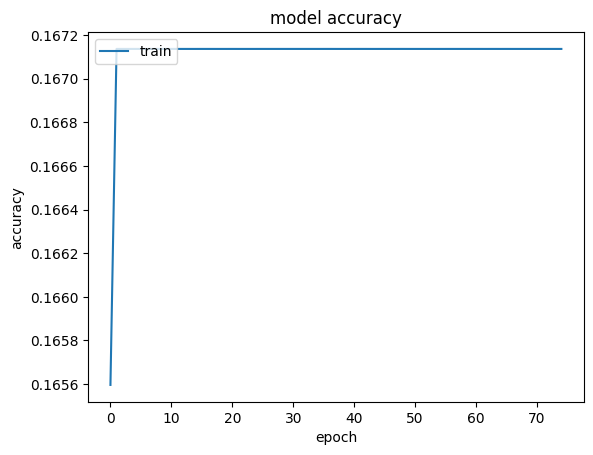

In [18]:
plt.plot(results.history['jacard_coef'])
#plt.plot(results.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

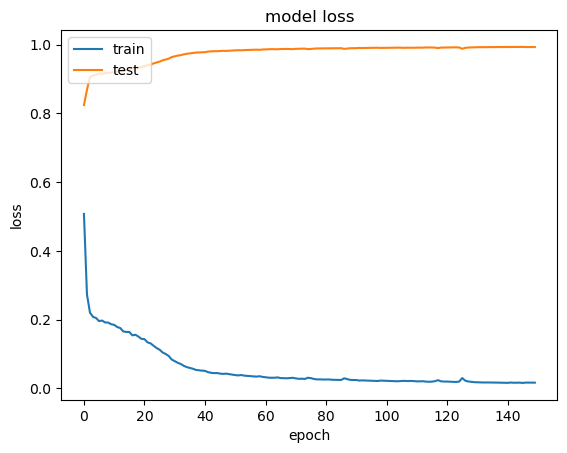

In [78]:
plt.plot(results.history['loss'])
plt.plot(results.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [79]:
#image_num= random.randint(0,len(X_test)-1)
image_num = 0

In [80]:
y_test.shape[0]

5

In [81]:
IoUs = np.zeros(y_test.shape[0])
total = 0

for u in range (0, y_test.shape[0]):
  test_predict = model.predict(np.expand_dims(X_test[u],0))
  test_predict = np.asarray(test_predict)
  IoUs[u] = jaccard_score((test_predict>.5).squeeze(), y_test[u].squeeze(), average='micro')
  total = IoUs[u] + total

average = total / y_test.shape[0]

ValueError: in user code:

    File "/Users/anshugusain/tf-nuclei/env/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/Users/anshugusain/tf-nuclei/env/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/anshugusain/tf-nuclei/env/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/anshugusain/tf-nuclei/env/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/Users/anshugusain/tf-nuclei/env/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/anshugusain/tf-nuclei/env/lib/python3.8/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 256, 256, 10), found shape=(None, 256, 256, 5)


In [75]:
average

0.8917037363899508

TypeError: Invalid shape (256, 256, 5) for image data

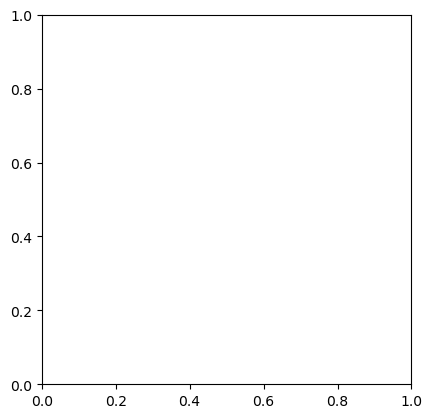

In [13]:
plt.imshow(X_test[image_num])

1/1 [==============================] - 0s 127ms/step


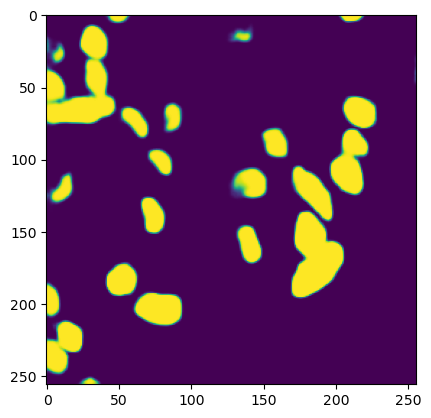

In [14]:
test_predict = model.predict(np.expand_dims(X_test[image_num],0))
test_predict = np.asarray(test_predict)
plt.imshow(test_predict.squeeze())

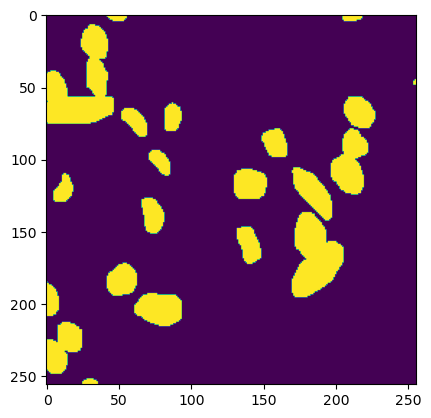

In [15]:
plt.imshow(y_test[image_num].squeeze())

In [16]:
IoU = jaccard_score((test_predict>.5).squeeze(), y_test[image_num].squeeze(), average='micro')
IoU

0.9238147138964578

In [17]:
f1score = f1_score(y_test[image_num].squeeze(), (test_predict>.4).squeeze(), average='micro')
f1score

0.9606713286713288

In [18]:
accuracy = accuracy_score((test_predict>.3).squeeze(), y_test[image_num].squeeze(), normalize=True)
accuracy

0.21484375